In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

# Table of Content <span id="toc"></span>

- [Introduction](#intro)
    - [Presentation of training datas](#presentation_datas)
    - [Grid search over hyper-parameters](#grid_search)
- [Training set size analysis](#train_size)
- [Hops analysis](#hops)
- [Batch size analysis](#batch_size)
- [Outline](#outline)
    - [Best model](#best_model)
---

# Introduction <a class="btn btn-light" id="intro" href="#toc"> go back to summary </a>

Study of the variation of different hyper-parameters (train set size, hops, batch size) for the chatbot [MemN2N Chatbot in Tensorflow](https://github.com/vyraun/chatbot-MemN2N-tensorflow).

The test are all made on the task 5, described in [Learning End-to-End Goal-Oriented Dialog](https://arxiv.org/abs/1605.07683) :

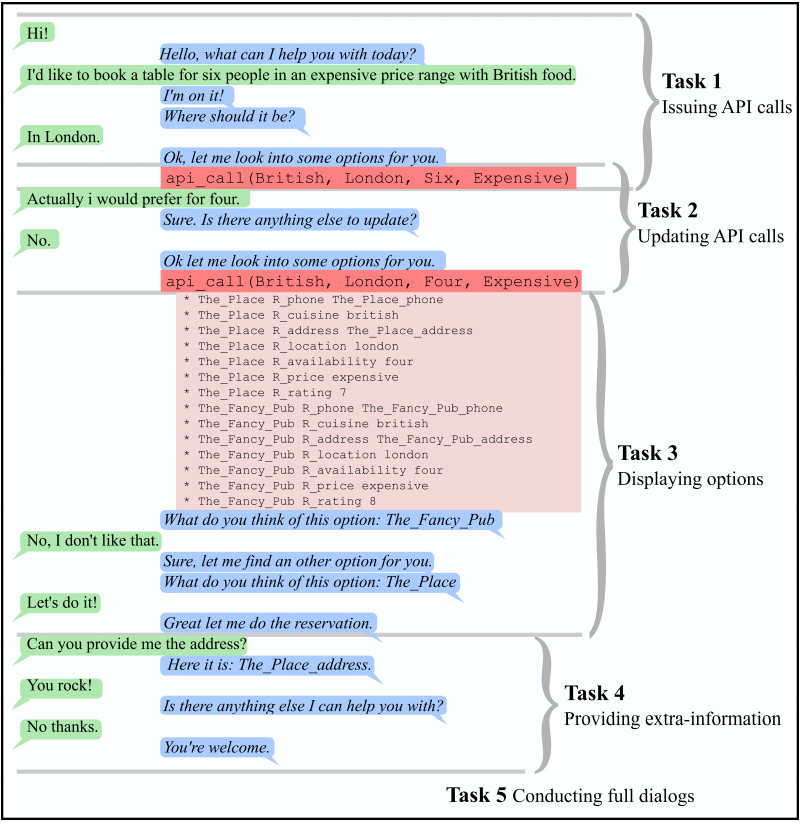

In [4]:
Image(filename='Learning End-to-End Goal-Oriented Dialog.png', width=550)

## Presentation of training datas <a class="btn btn-light" id="presentation_datas" href="#toc"> go back to summary </a>

Datas are from the dialog bAbI tasks.We only use the datas of **task 5**

### data shape (task 5)

Datas contains dialogs. Each dialogs are similar to the illustration above.

> The file format for each task is as follows:
> `ID user_utterance [tab] bot_utterances`
>
> The IDs for a given  dialog start at 1 and increase. When the IDs in a file reset back to 1 you can consider 
> the following sentences as a new dialog. When the bot speaks two times in a row, we used the special token 
> "SILENCE" to fill in for the missing user utterance.
    
#### Example of a dialog :

```
1 good morning	hello what can i help you with today
2 i'd like to book a table with italian food	i'm on it
3 <SILENCE>	where should it be
4 in paris	how many people would be in your party
5 for six people please	which price range are looking for
6 in a cheap price range please	ok let me look into some options for you
7 <SILENCE>	api_call italian paris six cheap
8 actually i would prefer for two people	sure is there anything else to update
9 instead could it be in madrid	sure is there anything else to update
10 instead could it be with spanish food	sure is there anything else to update
11 no	ok let me look into some options for you
12 <SILENCE>	api_call spanish madrid two cheap
13 resto_madrid_cheap_spanish_1stars R_phone resto_madrid_cheap_spanish_1stars_phone
14 resto_madrid_cheap_spanish_1stars R_cuisine spanish
.. ... list of facts ...
32 resto_madrid_cheap_spanish_8stars R_price cheap
33 resto_madrid_cheap_spanish_8stars R_rating 8
34 <SILENCE>	what do you think of this option: resto_madrid_cheap_spanish_8stars
35 no this does not work for me	sure let me find an other option for you
36 <SILENCE>	what do you think of this option: resto_madrid_cheap_spanish_6stars
37 do you have something else	sure let me find an other option for you
38 <SILENCE>	what do you think of this option: resto_madrid_cheap_spanish_1stars
39 it's perfect	great let me do the reservation
40 may i have the phone number of the restaurant	here it is resto_madrid_cheap_spanish_1stars_phone
41 thanks	is there anything i can help you with
42 no thank you	you're welcome
```

### train / validation / set

Here the full raw datas hosted on github : [train set](https://raw.githubusercontent.com/vyraun/chatbot-MemN2N-tensorflow/master/data/dialog-bAbI-tasks/dialog-babi-task5-full-dialogs-trn.txt) - [validation set](https://raw.githubusercontent.com/vyraun/chatbot-MemN2N-tensorflow/master/data/dialog-bAbI-tasks/dialog-babi-task5-full-dialogs-dev.txt) - [test set](https://raw.githubusercontent.com/vyraun/chatbot-MemN2N-tensorflow/master/data/dialog-bAbI-tasks/dialog-babi-task5-full-dialogs-tst.txt)

Each sets contain 1000 dialogs.

Size used by the model : *(I suppose it's the number of turns)*
- train set : 18340
- validation set : 18457
- test set : 18398
 
---

*for more informations, visit the [github page](https://github.com/vyraun/chatbot-MemN2N-tensorflow/tree/master/data/dialog-bAbI-tasks)*


## Grid search over hyper-parameters <a class="btn btn-light" id="grid_search" href="#toc"> go back to summary </a>

We will study the variation of three hyper-parameters :
- number of training examples
- number of hops
- batch size

Each models will be trained on the same basis :
- 100 epochs
- validation set of size 18457
- test set of size 18398

With a variation on a unique hyper-parameter at a time :
- number of training examples : from 183 to 18340
- number of hops : from 1 to 6
- batch size : from 8 to 256

*The other two hyper-parameters are fixed to there default values (18340 training examples, batch size of 32 & 3 hops).*

And we will analyze and compare the impact of these hyper-parameters on :
- the computer calculation time necessary to train the models
- the accuracy on test (final accuracy and over epochs) 
- the accuracy on train / validation over epochs

---
# Training set size analysis <a class="btn btn-light" id="train_size" href="#toc"> go back to summary </a>

## Data preprocessing

In [39]:
datas_train_size = pd.read_csv('metrics/train_size.csv', delimiter=',',
            names=['model_id', 'task_id', 'hops', 'nb_epoch',
                   'epoch', 'epoch_date', 'epoch_timestamp', 
                   'train_size_prct', 'train_size', 'val_size', 'test_size',
                   'train_acc', 'val_acc', 'test_acc'])

# we add a column name, containing the id, the task, train_size
datas_train_size['model_name'] = '' + datas_train_size['model_id'] + \
                              ' (e=' +datas_train_size['train_size'].astype(str) + ')'

# the model_name can be considered as a primary key

## Models Presentation

We use as basis this model :

In [40]:
datas_train_size.loc[datas_train_size['model_id'] == 'a',
                     ['hops', 'nb_epoch', 'val_size', 'test_size']].drop_duplicates()

,hops,nb_epoch,val_size,test_size
11,3,100,18457,18398


batch size is **32**.

And we only change the number of training examples used in the training set :

In [41]:
models = datas_train_size[['model_id', 'train_size', 'model_name']].drop_duplicates().sort_values('model_id')
models

,model_id,train_size,model_name
11,a,18340,a (e=18340)
9,b,12838,b (e=12838)
7,c,9170,c (e=9170)
4,d,5502,d (e=5502)
2,e,1834,e (e=1834)
1,f,917,f (e=917)
0,g,183,g (e=183)


#### Computer calculation time

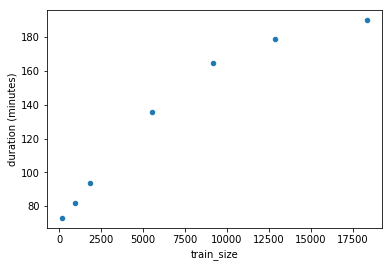

In [42]:
df = datas_train_size[['train_size','epoch_timestamp']].groupby('train_size').agg({'epoch_timestamp': [min, max]}).reset_index()
df.columns = ['train_size', 'start', 'end']
df['duration (minutes)'] = np.round((df.end - df.start) / 60.).astype(int)
_ = df[['train_size', 'duration (minutes)']].plot.scatter(x='train_size', y='duration (minutes)')

*Note : Models were trained in parrallel, so the CPU disponibility for each one changes over time. Because all models were launched simultaneously, we can still sort them by computer calculation time*

## Analysis

### Accuracy on test

##### best accuracy

In [43]:
datas_train_size.groupby('model_name').agg({'test_acc': max})

,test_acc
model_name,
a (e=18340),0.972334
b (e=12838),0.754539
c (e=9170),0.626481
d (e=5502),0.373682
e (e=1834),0.282368
f (e=917),0.258452
g (e=183),0.163061


<div class="alert alert-success" role="alert">

**Note :** 

The best model (a), has an accuracy of **97%** on test

</div>

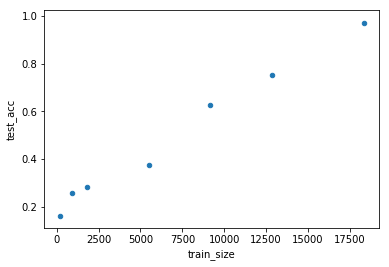

In [44]:
df = datas_train_size.groupby(['model_name', 'train_size']).agg({'test_acc': max}).reset_index()
_ = df.plot(x='train_size', y='test_acc', kind='scatter')

<div class="alert alert-success" role="alert">

**Note :** 

The relation between the number of training examples used and the accuracy seems linear

</div>

##### evolution over epochs

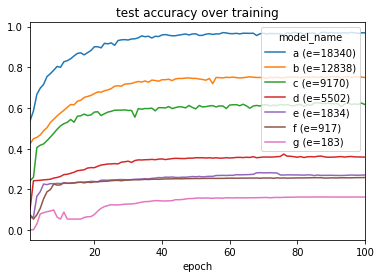

In [45]:
df = datas_train_size[['model_name', 'train_size_prct', 'epoch', 'test_acc']].copy()
df = pd.pivot_table(df, values='test_acc', columns=['model_name'], index='epoch')

_ = df.plot(title='test accuracy over training')

<div class="alert alert-success" role="alert">

**Note**
- the more learning data there is:
    - the longer it takes for the model to converge
    - the better its accuracy when it converges
    
</div>

### Accuracy on train / valid : Comparison over models

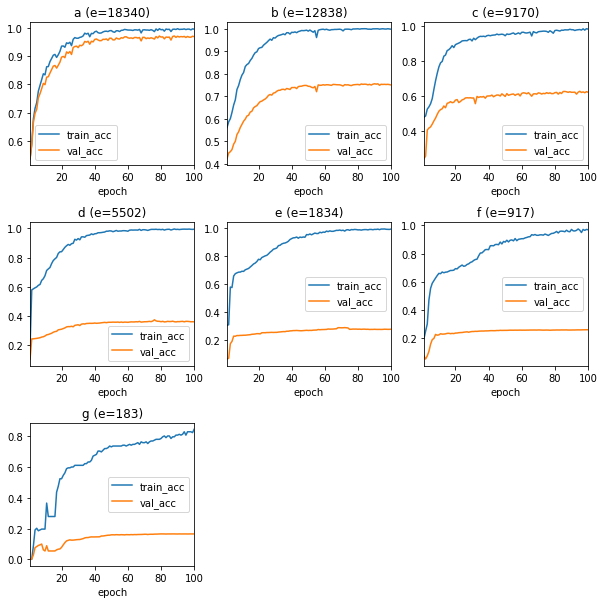

In [46]:
number_of_models = len(np.unique(datas_train_size.model_id))

# creating subplots
fig = plt.figure(figsize=(10,10))

ax = []
for i in range(number_of_models):
    ax_i = fig.add_subplot(331+i)
    ax.append(ax_i)
    
i = 0
for model_name, group in datas_train_size[['model_name', 'epoch', 'train_acc', 'val_acc']].groupby('model_name'):
    plot = group.plot(x='epoch', title = model_name, ax=ax[i])
    i += 1
    
plt.subplots_adjust(hspace=0.4)

<div class="alert alert-success" role="alert">

**Note**
- Even with a small amount of datas (model g, 183 examples), the model fit well the questions to the answer **on the train set** (model g has 0.847 accurcay)
- the less learning data there is, the more the model overfit on them.

</div>

---

# Hops analysis <a class="btn btn-light" id="hops" href="#toc"> go back to summary </a>

 *A hop consists of reading and addressing a memory slot*

## Data preprocessing

In [47]:
datas_hops = pd.read_csv('metrics/hops.csv', delimiter=',',
            names=['model_id', 'task_id', 'hops', 'nb_epoch',
                   'epoch', 'epoch_date', 'epoch_timestamp', 
                   'train_size_prct', 'train_size', 'val_size', 'test_size',
                   'train_acc', 'val_acc', 'test_acc'])

# we add a column name, containing the id, the task, train_size
datas_hops['model_name'] = '' + datas_hops['model_id'] + \
                        ' (h=' +datas_hops['hops'].astype(str) + ')'

# the model_name can be considered as a primary key

## Models Presentation

We use as basis this model :

In [48]:
datas_hops.loc[datas_train_size['model_id'] == 'a',
                     ['nb_epoch', 'train_size', 'val_size', 'test_size']].drop_duplicates()

,nb_epoch,train_size,val_size,test_size
11,100,18340,18457,18398


batch size if **32**

And we only change the number of hops of the model :

In [49]:
models = datas_hops[['model_id', 'hops', 'model_name']].drop_duplicates().sort_values('model_id')
models.columns = ['model id', 'hops', 'model name']
models

,model id,hops,model name
0,h,1,h (h=1)
1,i,2,i (h=2)
2,j,3,j (h=3)
3,k,4,k (h=4)
4,l,5,l (h=5)
6,m,6,m (h=6)


#### Computer calculation time

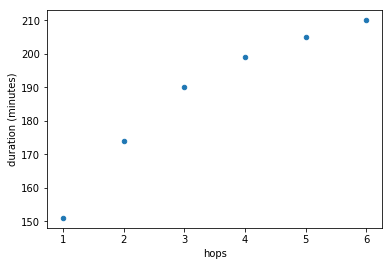

In [50]:
df = datas_hops[['hops','epoch_timestamp']].groupby('hops').agg({'epoch_timestamp': [min, max]}).reset_index()
df.columns = ['hops', 'start', 'end']
df['duration (minutes)'] = np.round((df.end - df.start) / 60.).astype(int)
_ = df[['hops', 'duration (minutes)']].plot.scatter(x='hops', y='duration (minutes)')

*Note : Models were trained in parrallel, so the CPU disponibility for each one changes over time. Because all models were launched simultaneously, we can still sort them by computer calculation time*

<div class="alert alert-success" role="alert">

**Note**
- The more there is hops, the more the training is long

</div>

## Analysis

### Accuracy on test

##### best accuracy

(0.9550500054353734, 0.9835302750298944)

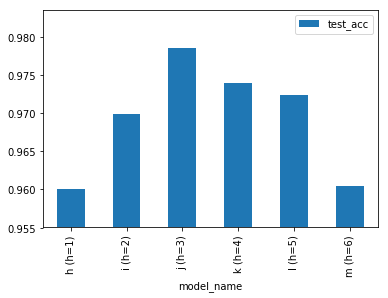

In [51]:
best_acc = datas_hops.groupby('model_name').agg({'test_acc': max})
maxi, mini = best_acc.max()[0], best_acc.min()[0]
a = best_acc.plot.bar()
a.set_ylim([mini-0.005, maxi+0.005])

<div class="alert alert-success" role="alert">

**Note :** 

- Hops doesn't impact much accuracy (**0.018** of amplitude)

- It seems that hops = 3 gives the best accuracy (0.979)

</div>

### Accuracy on train / valid : Comparison over models

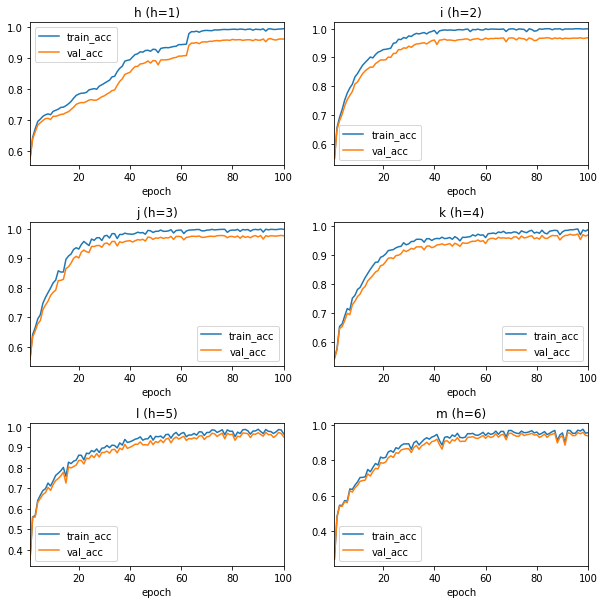

In [52]:
number_of_models = len(np.unique(datas_hops.model_id))

# creating subplots
fig = plt.figure(figsize=(10,10))

ax = []
for i in range(number_of_models):
    ax_i = fig.add_subplot(321+i)
    ax.append(ax_i)
    
i = 0
for model_name, group in datas_hops[['model_name', 'epoch', 'train_acc', 'val_acc']].groupby('model_name'):
    plot = group.plot(x='epoch', title = model_name, ax=ax[i])
    i += 1
    
plt.subplots_adjust(hspace=0.4)

<div class="alert alert-success" role="alert">

**Note :** 

- The bigger the hop is, the lesser the model seems to overfit on the training datas.

- interestingly, the model with the best accuracy on test (model j, whith hops of 3) seems to overfit more than models l & m 

</div>

---

# Batch size analysis <a class="btn btn-light" id="batch_size" href="#toc"> go back to summary </a>

## Data preprocessing

In [53]:
datas_batch_size = pd.read_csv('metrics/batch_size.csv', delimiter=',',
            names=['model_id', 'task_id', 'batch_size', 'hops', 'nb_epoch',
                   'epoch', 'epoch_date', 'epoch_timestamp', 
                   'train_size_prct', 'train_size', 'val_size', 'test_size',
                   'train_acc', 'val_acc', 'test_acc'])

# we add a column name
datas_batch_size['model_name'] = '' + datas_batch_size['model_id'] + \
                              ' (b=' +datas_batch_size['batch_size'].astype(str) + ')'

# the model_name can be considered as a primary key

## Models Presentation

We use as basis this model :

In [55]:
datas_batch_size.loc[datas_batch_size['model_id'] == 'q',
                     ['hops', 'nb_epoch', 'train_size', 'val_size', 'test_size']].drop_duplicates()

,hops,nb_epoch,train_size,val_size,test_size
3,3,100,18340,18457,18398


And we only change the batch size :

In [56]:
models = datas_batch_size[['model_id', 'batch_size', 'model_name']].drop_duplicates().sort_values('model_id')
models

,model_id,batch_size,model_name
51,n,1,n (b=1)
8,o,8,o (b=8)
4,p,16,p (b=16)
3,q,32,q (b=32)
2,r,64,r (b=64)
0,s,128,s (b=128)
1,t,256,t (b=256)


**Note** : the model n didn't finish its training. It only performed 43 epochs out of 100.

#### Computer calculation time

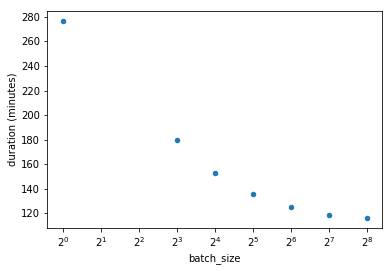

In [58]:
df = datas_batch_size[['batch_size','epoch_timestamp']].groupby('batch_size').agg({'epoch_timestamp': [min, max]}).reset_index()
df.columns = ['batch_size', 'start', 'end']
df['duration (minutes)'] = np.round((df.end - df.start) / 60.).astype(int)
a = df[['batch_size', 'duration (minutes)']].plot.scatter(x='batch_size', y='duration (minutes)')
a.set_xscale('log', basex=2)

*Note* : 
- the model n didn't finish to learn completly. It only performed 43 epochs
- Models were trained in parrallel, so the CPU disponibility for each one changes over time. Because all models were launched simultaneously, we can still sort them by computer calculation time*

<div class="alert alert-success" role="alert">

**Note :** 

- Bigger batches seems to increase learning speed

</div>

## Analysis

### Accuracy on test

##### best accuracy

In [65]:
datas_batch_size.groupby('model_name').agg({'test_acc': max}).sort_values('test_acc')

,test_acc
model_name,
n (b=1),0.873193
t (b=256),0.910425
s (b=128),0.971193
p (b=16),0.973204
q (b=32),0.974834
r (b=64),0.976139
o (b=8),0.977117


<div class="alert alert-success" role="alert">

**Note :** 

- a batch size of 64 (model r) gives the best accuracy (0.976)

</div>

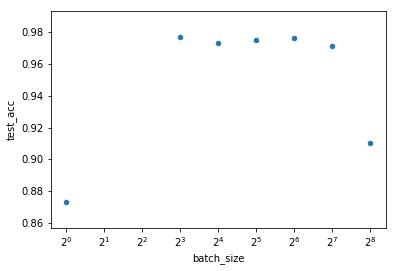

In [66]:
df = datas_batch_size.groupby(['model_name', 'batch_size']).agg({'test_acc': max}).reset_index()
a = df.plot(x='batch_size', y='test_acc', kind='scatter')
a.set_xscale('log', basex=2)

<div class="alert alert-success" role="alert">

**Note :** 

- from batch size of 128, the accuracy seems to decrease

</div>

##### evolution over epochs

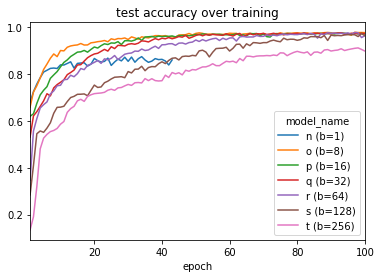

In [67]:
df = datas_batch_size[['model_name', 'train_size_prct', 'epoch', 'test_acc']].copy()
df = pd.pivot_table(df, values='test_acc', columns=['model_name'], index='epoch')

_ = df.plot(title='test accuracy over training')

<div class="alert alert-success" role="alert">

**Note :** 

- the smaller the batch is, the quicker the model converge
- the model *n*, even if it didn't finish its training, seems to converge to an accuracy around 0.87

</div>

### Accuracy on train / valid : Comparison over models

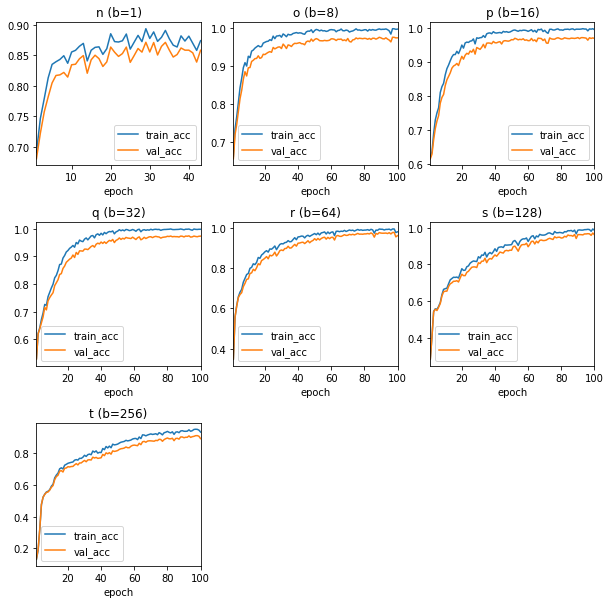

In [68]:
number_of_models = len(np.unique(datas_batch_size.model_id))

# creating subplots
fig = plt.figure(figsize=(10,10))

ax = []
for i in range(number_of_models):
    ax_i = fig.add_subplot(331+i)
    ax.append(ax_i)
    
i = 0
for model_name, group in datas_batch_size[['model_name', 'epoch', 'train_acc', 'val_acc']].groupby('model_name'):
    plot = group.plot(x='epoch', title = model_name, ax=ax[i])
    i += 1
    
plt.subplots_adjust(hspace=0.4)

<div class="alert alert-success" role="alert">

**Note :** 
 
- It seems that bigger batches prevent a bit overfitting
- stochastic gradient descent (model n, with batch of 1) produce an accuracy that oscillates over training.

</div>

---
# Outline <a class="btn btn-light" id="outline" href="#toc"> go back to summary </a>

## Training set size analysis

- The relation between the number of training examples used and the accuracy seems linear

- the more learning data there is:
    - the longer it takes for the model to converge
    - the better its accuracy when it converges
    
- Even with a small amount of datas (model g, 183 examples), the model fit well the questions to the answer **on the train set** (model g has 0.847 accurcay)

- the less learning data there is, the more the model overfit on them.

## Hops analysis

- the more there is hops, the more the training is long
- Hops doesn't impact much accuracy (**0.018** of amplitude)
- It seems that hops = 3 gives the best accuracy (0.979)
- The bigger the hop is, the lesser the model seems to overfit on the training datas.

## batch size analysis

- Bigger batches seems to increase learning speed
- from batch size of 128, the accuracy seems to decrease
- the smaller the batch is, the quicker the model converge
- It seems that bigger batches prevent a bit overfitting

## Best model <a class="btn btn-light" id="best_model" href="#toc"> go back to summary </a>

On all model trained, the one with the highest accuracy on test is the model `f` :

In [75]:
datas_all = pd.concat([datas_batch_size, datas_hops, datas_train_size], sort=True)

In [76]:
test_acc_max = datas_all['test_acc'].max()
datas_all[datas_all['test_acc'] == test_acc_max]

,batch_size,epoch,epoch_date,epoch_timestamp,hops,model_id,model_name,nb_epoch,task_id,test_acc,test_size,train_acc,train_size,train_size_prct,val_acc,val_size
512,NaN,95,"""23/07/2019 19:22:48""",1.563903e+09,3,j,j (h=3),100,5,0.97853,18398,0.997601,18340,1.0,0.97589,18457


<div class="alert alert-success" role="alert">

Model `f` reaches **97.9%** test accuracy on epoch **95**.

These hyper-paramaters are :
- hops of **3**
- train_size of **18340** (all the training set)
- batch_size of **32**

</div>

---
## Next steps :
- train on more than 100 epochs
- analyze errors made by the model